In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
import torchvision
import torchvision.transforms as transforms
# from tqdm import tqdm
from tqdm.notebook import tqdm
# !pip install torcheval
from torcheval.metrics import MulticlassAccuracy, MulticlassAUROC
import math

In [3]:
def to_device(obj):
    if torch.cuda.is_available():
        obj = obj.to("cuda")
    elif torch.mps.is_available():
        obj = obj.to("mps")
    return obj

# Data augmentation and loader

In [4]:
preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #  transforms.RandomAffine(
    #      degrees=(-30, 30),
    #      translate=(0.1, 0.1),
    #      scale=(0.8, 1.2),
    #      shear=(-10, 10)
    #  ),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=preprocess)
cifar_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=preprocess)

batch_size = 512
cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train, batch_size=batch_size, shuffle=True, num_workers=4)
cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Model Definition

In [6]:
class ConvPatch(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, hidden_size):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        return x.flatten(2).transpose(1, 2)


class Embeddings(nn.Module):
    def __init__(self, image_size, patch_size, num_channels, hidden_size, dropout_prob):
        super().__init__()
        self.patch_embeddings = ConvPatch(image_size, patch_size, num_channels, hidden_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size)) # [CLS] token acts as global representation vector after Transformer Encoder
        self.position_embeddings = nn.Parameter(
            torch.randn(1, self.patch_embeddings.num_patches + 1, hidden_size)
        ) # Learnable position embeddings as opposed to sinusoidal embeddings
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # Concatenate [CLS] token
        x = x + self.position_embeddings
        return self.dropout(x)


class ViTForClassification(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        num_channels,
        hidden_size,
        num_layers,
        num_heads,
        intermediate_size,
        num_classes,
        dropout_prob,
    ):
        super().__init__()
        self.embeddings = Embeddings(
            image_size, patch_size, num_channels, hidden_size, dropout_prob
        )


        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=intermediate_size,
            dropout=dropout_prob,
            activation="gelu",
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.encoder(x)
        return self.classifier(x[:, 0])  # Use the [CLS] token for classification

In [14]:
model = ViTForClassification(image_size=32,
                             patch_size=4,
                             num_channels=3,
                             hidden_size=192,
                             num_layers=12,
                             num_heads=6,
                             intermediate_size=4*192,
                             num_classes=10,
                             dropout_prob=0.0)
model = to_device(model)

# Optimizer and Warmup Cosine Scheduler

In [15]:
class WarmupCosineLRScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, warmup_epochs: int, max_epochs: int, min_lr: float = 0.0, last_epoch: int = -1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.min_lr = min_lr
        super(WarmupCosineLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # Current epoch
        epoch = self.last_epoch + 1

        # Warmup phase
        if epoch <= self.warmup_epochs:
            return [base_lr * epoch / self.warmup_epochs for base_lr in self.base_lrs]

        # Cosine decay phase
        decay_epochs = epoch - self.warmup_epochs
        total_decay_epochs = self.max_epochs - self.warmup_epochs
        cosine_factor = 0.5 * (1 + math.cos(math.pi * decay_epochs / total_decay_epochs))
        return [self.min_lr + (base_lr - self.min_lr) * cosine_factor for base_lr in self.base_lrs]

In [16]:
optimizer_params = {
    "lr": 1e-3,
    "weight_decay": .1
}
optimizer = optim.AdamW(model.parameters(), **optimizer_params)

In [17]:
warmup_epochs = 100
nepochs = 500
min_lr = 1e-5

scheduler = WarmupCosineLRScheduler(optimizer, warmup_epochs, nepochs, min_lr)

# Checkpoint

In [18]:
import os

def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully.")
    else:
        print(f"Folder '{folder_name}' already exists.")

folder_name = "model_checkpoints"

create_folder(folder_name)


Folder 'model_checkpoints' already exists.


In [19]:
min_loss = float("inf")

def check_point(epoch, accuracy, val_loss, auc_score):
    global min_loss
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model, f"model_checkpoints/vit_epoch_{epoch}_acc_{accuracy:.2f}_loss_{val_loss:.4f}_auc_{auc_score:.4f}.pth")


# Training

In [20]:
criterion = nn.CrossEntropyLoss()

num_classes = 10
accuracy_metric = MulticlassAccuracy(num_classes=num_classes)
auc_metric = MulticlassAUROC(num_classes=num_classes)

metrics = []

def test(model, loader):
    model.eval()
    val_loss = 0
    accuracy_metric.reset()
    auc_metric.reset()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = to_device(inputs)
            labels = to_device(labels)

            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Update metrics
            accuracy_metric.update(outputs, labels)
            auc_metric.update(outputs, labels)

        # Calculate final metrics
        avg_val_loss = val_loss / len(loader)
        accuracy = accuracy_metric.compute().item() * 100
        auc_score = auc_metric.compute().item()

    return accuracy, avg_val_loss, auc_score

for epoch in range(nepochs):
    print("Epoch {}/{}".format(epoch + 1, nepochs))

    # Training loop
    model.train()
    for inputs, labels in tqdm(cifar_train_loader):
        inputs = to_device(inputs)
        labels = to_device(labels)

        # Zero out the gradients before every iteration!
        optimizer.zero_grad()

        # forward + backward + optimizer step
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()

    accuracy, val_loss, auc_score = test(model, cifar_test_loader)
    check_point(epoch, accuracy, val_loss, auc_score)
    metrics.append((accuracy, val_loss, auc_score))

    # Open the file in append mode
    with open(f"./{folder_name}/metrics.txt", "a") as file:
        # Write the content to append
        file.write(f"{accuracy}, {val_loss}, {auc_score}, {scheduler.get_last_lr()[0]}\n")


    print(f'Epoch {epoch+1}, Val Acc: {accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val AUC: {auc_score:.4f}, LR: {scheduler.get_last_lr()[0]}')

Epoch 1/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1, Val Acc: 17.97%, Val Loss: 2.1706, Val AUC: 0.6465, LR: 2e-05
Epoch 2/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2, Val Acc: 19.66%, Val Loss: 2.1406, Val AUC: 0.6690, LR: 3e-05
Epoch 3/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3, Val Acc: 22.45%, Val Loss: 2.1130, Val AUC: 0.6828, LR: 4e-05
Epoch 4/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4, Val Acc: 24.42%, Val Loss: 2.0890, Val AUC: 0.6921, LR: 5e-05
Epoch 5/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5, Val Acc: 25.96%, Val Loss: 2.0472, Val AUC: 0.7114, LR: 6e-05
Epoch 6/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6, Val Acc: 27.90%, Val Loss: 1.9937, Val AUC: 0.7294, LR: 7.000000000000001e-05
Epoch 7/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7, Val Acc: 28.87%, Val Loss: 1.9673, Val AUC: 0.7440, LR: 8e-05
Epoch 8/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8, Val Acc: 30.66%, Val Loss: 1.9190, Val AUC: 0.7586, LR: 9e-05
Epoch 9/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9, Val Acc: 33.12%, Val Loss: 1.8549, Val AUC: 0.7729, LR: 0.0001
Epoch 10/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10, Val Acc: 34.27%, Val Loss: 1.8012, Val AUC: 0.7847, LR: 0.00010999999999999999
Epoch 11/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11, Val Acc: 35.87%, Val Loss: 1.7701, Val AUC: 0.7930, LR: 0.00012
Epoch 12/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12, Val Acc: 35.79%, Val Loss: 1.7871, Val AUC: 0.7958, LR: 0.00013000000000000002
Epoch 13/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13, Val Acc: 36.81%, Val Loss: 1.7288, Val AUC: 0.8063, LR: 0.00014000000000000001
Epoch 14/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14, Val Acc: 39.87%, Val Loss: 1.6949, Val AUC: 0.8116, LR: 0.00015
Epoch 15/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15, Val Acc: 40.03%, Val Loss: 1.6507, Val AUC: 0.8192, LR: 0.00016
Epoch 16/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16, Val Acc: 40.36%, Val Loss: 1.6839, Val AUC: 0.8187, LR: 0.00017
Epoch 17/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17, Val Acc: 41.43%, Val Loss: 1.6186, Val AUC: 0.8281, LR: 0.00018
Epoch 18/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18, Val Acc: 42.37%, Val Loss: 1.6003, Val AUC: 0.8319, LR: 0.00018999999999999998
Epoch 19/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19, Val Acc: 43.96%, Val Loss: 1.5657, Val AUC: 0.8379, LR: 0.0002
Epoch 20/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20, Val Acc: 44.70%, Val Loss: 1.5464, Val AUC: 0.8415, LR: 0.00021
Epoch 21/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21, Val Acc: 44.80%, Val Loss: 1.5330, Val AUC: 0.8424, LR: 0.00021999999999999998
Epoch 22/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22, Val Acc: 46.23%, Val Loss: 1.5061, Val AUC: 0.8471, LR: 0.00023
Epoch 23/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23, Val Acc: 45.67%, Val Loss: 1.5062, Val AUC: 0.8496, LR: 0.00024
Epoch 24/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24, Val Acc: 46.31%, Val Loss: 1.4752, Val AUC: 0.8528, LR: 0.00025
Epoch 25/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25, Val Acc: 48.12%, Val Loss: 1.4463, Val AUC: 0.8577, LR: 0.00026000000000000003
Epoch 26/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26, Val Acc: 47.07%, Val Loss: 1.4764, Val AUC: 0.8554, LR: 0.00027
Epoch 27/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27, Val Acc: 48.19%, Val Loss: 1.4514, Val AUC: 0.8589, LR: 0.00028000000000000003
Epoch 28/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28, Val Acc: 49.07%, Val Loss: 1.4321, Val AUC: 0.8646, LR: 0.00029
Epoch 29/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29, Val Acc: 50.14%, Val Loss: 1.4102, Val AUC: 0.8669, LR: 0.0003
Epoch 30/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30, Val Acc: 51.09%, Val Loss: 1.3766, Val AUC: 0.8692, LR: 0.00031
Epoch 31/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 31, Val Acc: 50.65%, Val Loss: 1.3870, Val AUC: 0.8712, LR: 0.00032
Epoch 32/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 32, Val Acc: 51.44%, Val Loss: 1.3473, Val AUC: 0.8731, LR: 0.00033
Epoch 33/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 33, Val Acc: 52.13%, Val Loss: 1.3432, Val AUC: 0.8759, LR: 0.00034
Epoch 34/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 34, Val Acc: 52.76%, Val Loss: 1.3312, Val AUC: 0.8746, LR: 0.00035000000000000005
Epoch 35/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 35, Val Acc: 52.93%, Val Loss: 1.3162, Val AUC: 0.8803, LR: 0.00036
Epoch 36/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 36, Val Acc: 53.62%, Val Loss: 1.2896, Val AUC: 0.8825, LR: 0.00037
Epoch 37/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 37, Val Acc: 54.04%, Val Loss: 1.2902, Val AUC: 0.8831, LR: 0.00037999999999999997
Epoch 38/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 38, Val Acc: 53.88%, Val Loss: 1.2926, Val AUC: 0.8834, LR: 0.00039
Epoch 39/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 39, Val Acc: 55.52%, Val Loss: 1.2592, Val AUC: 0.8861, LR: 0.0004
Epoch 40/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 40, Val Acc: 56.98%, Val Loss: 1.2240, Val AUC: 0.8909, LR: 0.00041
Epoch 41/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 41, Val Acc: 55.47%, Val Loss: 1.2621, Val AUC: 0.8926, LR: 0.00042
Epoch 42/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 42, Val Acc: 57.27%, Val Loss: 1.1950, Val AUC: 0.8961, LR: 0.00043000000000000004
Epoch 43/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 43, Val Acc: 57.14%, Val Loss: 1.2268, Val AUC: 0.8919, LR: 0.00043999999999999996
Epoch 44/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 44, Val Acc: 57.91%, Val Loss: 1.1839, Val AUC: 0.8966, LR: 0.00045
Epoch 45/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 45, Val Acc: 59.44%, Val Loss: 1.1437, Val AUC: 0.9006, LR: 0.00046
Epoch 46/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 46, Val Acc: 57.16%, Val Loss: 1.2000, Val AUC: 0.9041, LR: 0.00047
Epoch 47/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 47, Val Acc: 59.18%, Val Loss: 1.1579, Val AUC: 0.9035, LR: 0.00048
Epoch 48/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 48, Val Acc: 60.16%, Val Loss: 1.1153, Val AUC: 0.9095, LR: 0.00049
Epoch 49/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 49, Val Acc: 59.74%, Val Loss: 1.1394, Val AUC: 0.9020, LR: 0.0005
Epoch 50/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 50, Val Acc: 60.38%, Val Loss: 1.1234, Val AUC: 0.9059, LR: 0.00051
Epoch 51/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 51, Val Acc: 61.93%, Val Loss: 1.0851, Val AUC: 0.9122, LR: 0.0005200000000000001
Epoch 52/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 52, Val Acc: 60.70%, Val Loss: 1.1104, Val AUC: 0.9097, LR: 0.00053
Epoch 53/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 53, Val Acc: 61.79%, Val Loss: 1.0846, Val AUC: 0.9115, LR: 0.00054
Epoch 54/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 54, Val Acc: 62.81%, Val Loss: 1.0560, Val AUC: 0.9137, LR: 0.00055
Epoch 55/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 55, Val Acc: 63.33%, Val Loss: 1.0524, Val AUC: 0.9139, LR: 0.0005600000000000001
Epoch 56/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 56, Val Acc: 62.59%, Val Loss: 1.0645, Val AUC: 0.9169, LR: 0.00057
Epoch 57/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 57, Val Acc: 63.66%, Val Loss: 1.0272, Val AUC: 0.9179, LR: 0.00058
Epoch 58/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 58, Val Acc: 63.26%, Val Loss: 1.0264, Val AUC: 0.9184, LR: 0.00059
Epoch 59/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 59, Val Acc: 64.10%, Val Loss: 1.0241, Val AUC: 0.9177, LR: 0.0006
Epoch 60/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 60, Val Acc: 63.78%, Val Loss: 1.0093, Val AUC: 0.9203, LR: 0.00061
Epoch 61/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 61, Val Acc: 65.21%, Val Loss: 1.0028, Val AUC: 0.9201, LR: 0.00062
Epoch 62/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 62, Val Acc: 64.55%, Val Loss: 1.0069, Val AUC: 0.9231, LR: 0.00063
Epoch 63/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 63, Val Acc: 65.47%, Val Loss: 0.9895, Val AUC: 0.9231, LR: 0.00064
Epoch 64/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 64, Val Acc: 65.84%, Val Loss: 0.9730, Val AUC: 0.9229, LR: 0.00065
Epoch 65/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 65, Val Acc: 65.90%, Val Loss: 0.9737, Val AUC: 0.9264, LR: 0.00066
Epoch 66/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 66, Val Acc: 66.76%, Val Loss: 0.9508, Val AUC: 0.9281, LR: 0.00067
Epoch 67/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 67, Val Acc: 66.78%, Val Loss: 0.9619, Val AUC: 0.9291, LR: 0.00068
Epoch 68/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 68, Val Acc: 65.95%, Val Loss: 0.9704, Val AUC: 0.9258, LR: 0.0006900000000000001
Epoch 69/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 69, Val Acc: 66.67%, Val Loss: 0.9527, Val AUC: 0.9308, LR: 0.0007000000000000001
Epoch 70/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 70, Val Acc: 67.49%, Val Loss: 0.9317, Val AUC: 0.9311, LR: 0.0007100000000000001
Epoch 71/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 71, Val Acc: 66.35%, Val Loss: 0.9553, Val AUC: 0.9290, LR: 0.00072
Epoch 72/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 72, Val Acc: 67.15%, Val Loss: 0.9479, Val AUC: 0.9300, LR: 0.00073
Epoch 73/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 73, Val Acc: 67.67%, Val Loss: 0.9165, Val AUC: 0.9323, LR: 0.00074
Epoch 74/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 74, Val Acc: 67.31%, Val Loss: 0.9417, Val AUC: 0.9303, LR: 0.00075
Epoch 75/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 75, Val Acc: 68.78%, Val Loss: 0.8940, Val AUC: 0.9326, LR: 0.0007599999999999999
Epoch 76/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 76, Val Acc: 67.71%, Val Loss: 0.9159, Val AUC: 0.9324, LR: 0.00077
Epoch 77/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 77, Val Acc: 67.40%, Val Loss: 0.9373, Val AUC: 0.9334, LR: 0.00078
Epoch 78/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 78, Val Acc: 68.61%, Val Loss: 0.8903, Val AUC: 0.9361, LR: 0.00079
Epoch 79/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 79, Val Acc: 68.60%, Val Loss: 0.9073, Val AUC: 0.9346, LR: 0.0008
Epoch 80/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 80, Val Acc: 69.57%, Val Loss: 0.8796, Val AUC: 0.9376, LR: 0.0008100000000000001
Epoch 81/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 81, Val Acc: 69.44%, Val Loss: 0.8721, Val AUC: 0.9373, LR: 0.00082
Epoch 82/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 82, Val Acc: 68.07%, Val Loss: 0.9198, Val AUC: 0.9360, LR: 0.00083
Epoch 83/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 83, Val Acc: 69.86%, Val Loss: 0.8654, Val AUC: 0.9391, LR: 0.00084
Epoch 84/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 84, Val Acc: 68.75%, Val Loss: 0.9220, Val AUC: 0.9368, LR: 0.0008500000000000001
Epoch 85/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 85, Val Acc: 69.85%, Val Loss: 0.8720, Val AUC: 0.9387, LR: 0.0008600000000000001
Epoch 86/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 86, Val Acc: 69.34%, Val Loss: 0.8863, Val AUC: 0.9378, LR: 0.0008700000000000001
Epoch 87/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 87, Val Acc: 68.34%, Val Loss: 0.9026, Val AUC: 0.9368, LR: 0.0008799999999999999
Epoch 88/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 88, Val Acc: 70.20%, Val Loss: 0.8485, Val AUC: 0.9415, LR: 0.00089
Epoch 89/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 89, Val Acc: 70.44%, Val Loss: 0.8562, Val AUC: 0.9406, LR: 0.0009
Epoch 90/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 90, Val Acc: 70.59%, Val Loss: 0.8540, Val AUC: 0.9418, LR: 0.00091
Epoch 91/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 91, Val Acc: 69.32%, Val Loss: 0.8757, Val AUC: 0.9376, LR: 0.00092
Epoch 92/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 92, Val Acc: 70.42%, Val Loss: 0.8566, Val AUC: 0.9427, LR: 0.0009299999999999999
Epoch 93/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 93, Val Acc: 71.71%, Val Loss: 0.8182, Val AUC: 0.9427, LR: 0.00094
Epoch 94/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 94, Val Acc: 70.39%, Val Loss: 0.8632, Val AUC: 0.9419, LR: 0.00095
Epoch 95/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 95, Val Acc: 71.50%, Val Loss: 0.8300, Val AUC: 0.9457, LR: 0.00096
Epoch 96/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 96, Val Acc: 71.83%, Val Loss: 0.8299, Val AUC: 0.9438, LR: 0.00097
Epoch 97/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 97, Val Acc: 71.13%, Val Loss: 0.8274, Val AUC: 0.9456, LR: 0.00098
Epoch 98/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 98, Val Acc: 72.27%, Val Loss: 0.8036, Val AUC: 0.9450, LR: 0.00099
Epoch 99/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 99, Val Acc: 71.27%, Val Loss: 0.8330, Val AUC: 0.9412, LR: 0.001
Epoch 100/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 100, Val Acc: 71.36%, Val Loss: 0.8349, Val AUC: 0.9427, LR: 0.000999984733034171
Epoch 101/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 101, Val Acc: 71.41%, Val Loss: 0.8285, Val AUC: 0.9453, LR: 0.000999938933078422
Epoch 102/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 102, Val Acc: 72.61%, Val Loss: 0.8164, Val AUC: 0.9455, LR: 0.0009998626029579104
Epoch 103/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 103, Val Acc: 72.69%, Val Loss: 0.8052, Val AUC: 0.9456, LR: 0.0009997557473810372
Epoch 104/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 104, Val Acc: 72.02%, Val Loss: 0.8336, Val AUC: 0.9444, LR: 0.000999618372939158
Epoch 105/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 105, Val Acc: 72.08%, Val Loss: 0.8082, Val AUC: 0.9463, LR: 0.0009994504881061753
Epoch 106/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 106, Val Acc: 72.19%, Val Loss: 0.8289, Val AUC: 0.9464, LR: 0.0009992521032380164
Epoch 107/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 107, Val Acc: 72.12%, Val Loss: 0.8156, Val AUC: 0.9456, LR: 0.0009990232305719944
Epoch 108/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 108, Val Acc: 73.65%, Val Loss: 0.7758, Val AUC: 0.9500, LR: 0.0009987638842260537
Epoch 109/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 109, Val Acc: 71.28%, Val Loss: 0.8532, Val AUC: 0.9468, LR: 0.0009984740801978985
Epoch 110/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 110, Val Acc: 73.13%, Val Loss: 0.8183, Val AUC: 0.9476, LR: 0.000998153836364006
Epoch 111/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 111, Val Acc: 73.09%, Val Loss: 0.7865, Val AUC: 0.9482, LR: 0.0009978031724785245
Epoch 112/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 112, Val Acc: 72.90%, Val Loss: 0.8072, Val AUC: 0.9493, LR: 0.0009974221101720546
Epoch 113/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 113, Val Acc: 73.10%, Val Loss: 0.8026, Val AUC: 0.9499, LR: 0.000997010672950314
Epoch 114/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 114, Val Acc: 73.84%, Val Loss: 0.7775, Val AUC: 0.9504, LR: 0.0009965688861926887
Epoch 115/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 115, Val Acc: 74.34%, Val Loss: 0.7684, Val AUC: 0.9528, LR: 0.0009960967771506667
Epoch 116/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 116, Val Acc: 73.92%, Val Loss: 0.7985, Val AUC: 0.9504, LR: 0.0009955943749461575
Epoch 117/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 117, Val Acc: 74.25%, Val Loss: 0.7702, Val AUC: 0.9519, LR: 0.000995061710569696
Epoch 118/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 118, Val Acc: 73.64%, Val Loss: 0.7794, Val AUC: 0.9498, LR: 0.0009944988168785298
Epoch 119/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 119, Val Acc: 74.91%, Val Loss: 0.7510, Val AUC: 0.9532, LR: 0.0009939057285945933
Epoch 120/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 120, Val Acc: 74.12%, Val Loss: 0.7871, Val AUC: 0.9535, LR: 0.0009932824823023652
Epoch 121/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 121, Val Acc: 74.48%, Val Loss: 0.7645, Val AUC: 0.9530, LR: 0.000992629116446613
Epoch 122/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 122, Val Acc: 74.09%, Val Loss: 0.7863, Val AUC: 0.9502, LR: 0.0009919456713300204
Epoch 123/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 123, Val Acc: 73.94%, Val Loss: 0.7832, Val AUC: 0.9507, LR: 0.000991232189110701
Epoch 124/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 124, Val Acc: 74.84%, Val Loss: 0.7565, Val AUC: 0.9537, LR: 0.0009904887137995992
Epoch 125/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 125, Val Acc: 74.88%, Val Loss: 0.7821, Val AUC: 0.9544, LR: 0.0009897152912577741
Epoch 126/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 126, Val Acc: 75.60%, Val Loss: 0.7409, Val AUC: 0.9541, LR: 0.0009889119691935714
Epoch 127/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 127, Val Acc: 73.86%, Val Loss: 0.7986, Val AUC: 0.9524, LR: 0.00098807879715968
Epoch 128/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 128, Val Acc: 74.99%, Val Loss: 0.7861, Val AUC: 0.9555, LR: 0.0009872158265500754
Epoch 129/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 129, Val Acc: 74.63%, Val Loss: 0.7739, Val AUC: 0.9528, LR: 0.00098632311059685
Epoch 130/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 130, Val Acc: 74.49%, Val Loss: 0.7785, Val AUC: 0.9523, LR: 0.0009854007043669285
Epoch 131/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 131, Val Acc: 75.91%, Val Loss: 0.7439, Val AUC: 0.9557, LR: 0.0009844486647586723
Epoch 132/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 132, Val Acc: 75.43%, Val Loss: 0.7788, Val AUC: 0.9543, LR: 0.000983467050498369
Epoch 133/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 133, Val Acc: 75.27%, Val Loss: 0.7742, Val AUC: 0.9542, LR: 0.00098245592213661
Epoch 134/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 134, Val Acc: 74.96%, Val Loss: 0.7848, Val AUC: 0.9531, LR: 0.0009814153420445552
Epoch 135/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 135, Val Acc: 75.18%, Val Loss: 0.7730, Val AUC: 0.9560, LR: 0.0009803453744100868
Epoch 136/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 136, Val Acc: 75.98%, Val Loss: 0.7647, Val AUC: 0.9552, LR: 0.000979246085233848
Epoch 137/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 137, Val Acc: 75.84%, Val Loss: 0.7577, Val AUC: 0.9557, LR: 0.0009781175423251734
Epoch 138/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 138, Val Acc: 75.63%, Val Loss: 0.7584, Val AUC: 0.9545, LR: 0.0009769598152979055
Epoch 139/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 139, Val Acc: 75.60%, Val Loss: 0.7541, Val AUC: 0.9559, LR: 0.0009757729755661011
Epoch 140/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 140, Val Acc: 75.89%, Val Loss: 0.7522, Val AUC: 0.9554, LR: 0.0009745570963396248
Epoch 141/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 141, Val Acc: 75.58%, Val Loss: 0.7608, Val AUC: 0.9574, LR: 0.0009733122526196349
Epoch 142/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 142, Val Acc: 75.35%, Val Loss: 0.7993, Val AUC: 0.9546, LR: 0.0009720385211939559
Epoch 143/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 143, Val Acc: 75.45%, Val Loss: 0.7510, Val AUC: 0.9549, LR: 0.0009707359806323416
Epoch 144/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 144, Val Acc: 76.27%, Val Loss: 0.7263, Val AUC: 0.9569, LR: 0.0009694047112816297
Epoch 145/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 145, Val Acc: 76.37%, Val Loss: 0.7599, Val AUC: 0.9562, LR: 0.0009680447952607845
Epoch 146/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 146, Val Acc: 75.67%, Val Loss: 0.7656, Val AUC: 0.9560, LR: 0.0009666563164558316
Epoch 147/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 147, Val Acc: 75.00%, Val Loss: 0.7733, Val AUC: 0.9569, LR: 0.0009652393605146844
Epoch 148/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 148, Val Acc: 75.23%, Val Loss: 0.7626, Val AUC: 0.9570, LR: 0.0009637940148418598
Epoch 149/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 149, Val Acc: 74.87%, Val Loss: 0.8137, Val AUC: 0.9543, LR: 0.000962320368593087
Epoch 150/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 150, Val Acc: 75.41%, Val Loss: 0.8326, Val AUC: 0.9562, LR: 0.0009608185126698081
Epoch 151/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 151, Val Acc: 76.48%, Val Loss: 0.7508, Val AUC: 0.9588, LR: 0.0009592885397135706
Epoch 152/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 152, Val Acc: 76.36%, Val Loss: 0.7416, Val AUC: 0.9574, LR: 0.0009577305441003138
Epoch 153/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 153, Val Acc: 75.34%, Val Loss: 0.7996, Val AUC: 0.9554, LR: 0.0009561446219345453
Epoch 154/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 154, Val Acc: 76.08%, Val Loss: 0.7501, Val AUC: 0.9579, LR: 0.0009545308710434153
Epoch 155/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 155, Val Acc: 75.98%, Val Loss: 0.7754, Val AUC: 0.9568, LR: 0.0009528893909706797
Epoch 156/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 156, Val Acc: 76.25%, Val Loss: 0.7478, Val AUC: 0.9588, LR: 0.0009512202829705616
Epoch 157/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 157, Val Acc: 76.79%, Val Loss: 0.7665, Val AUC: 0.9589, LR: 0.0009495236500015047
Epoch 158/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 158, Val Acc: 76.38%, Val Loss: 0.7647, Val AUC: 0.9572, LR: 0.0009477995967198224
Epoch 159/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 159, Val Acc: 76.16%, Val Loss: 0.7752, Val AUC: 0.9585, LR: 0.0009460482294732421
Epoch 160/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 160, Val Acc: 77.15%, Val Loss: 0.7201, Val AUC: 0.9597, LR: 0.0009442696562943453
Epoch 161/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 161, Val Acc: 75.98%, Val Loss: 0.7876, Val AUC: 0.9564, LR: 0.0009424639868939033
Epoch 162/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 162, Val Acc: 77.31%, Val Loss: 0.7230, Val AUC: 0.9588, LR: 0.0009406313326541104
Epoch 163/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 163, Val Acc: 76.99%, Val Loss: 0.7384, Val AUC: 0.9594, LR: 0.0009387718066217125
Epoch 164/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 164, Val Acc: 77.47%, Val Loss: 0.7426, Val AUC: 0.9584, LR: 0.0009368855235010347
Epoch 165/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 165, Val Acc: 77.15%, Val Loss: 0.7537, Val AUC: 0.9590, LR: 0.0009349725996469047
Epoch 166/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 166, Val Acc: 77.96%, Val Loss: 0.7213, Val AUC: 0.9604, LR: 0.0009330331530574767
Epoch 167/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 167, Val Acc: 77.48%, Val Loss: 0.7323, Val AUC: 0.9616, LR: 0.0009310673033669522
Epoch 168/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 168, Val Acc: 77.08%, Val Loss: 0.7248, Val AUC: 0.9593, LR: 0.0009290751718381996
Epoch 169/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 169, Val Acc: 76.12%, Val Loss: 0.7977, Val AUC: 0.9581, LR: 0.0009270568813552756
Epoch 170/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 170, Val Acc: 76.38%, Val Loss: 0.7659, Val AUC: 0.9593, LR: 0.0009250125564158443
Epoch 171/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 171, Val Acc: 77.07%, Val Loss: 0.7528, Val AUC: 0.9594, LR: 0.0009229423231234975
Epoch 172/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 172, Val Acc: 77.65%, Val Loss: 0.7179, Val AUC: 0.9615, LR: 0.0009208463091799762
Epoch 173/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 173, Val Acc: 76.89%, Val Loss: 0.7545, Val AUC: 0.9579, LR: 0.0009187246438772938
Epoch 174/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 174, Val Acc: 77.82%, Val Loss: 0.7678, Val AUC: 0.9593, LR: 0.0009165774580897599
Epoch 175/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 175, Val Acc: 76.23%, Val Loss: 0.7786, Val AUC: 0.9578, LR: 0.0009144048842659081
Epoch 176/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 176, Val Acc: 77.75%, Val Loss: 0.7485, Val AUC: 0.9599, LR: 0.0009122070564203256
Epoch 177/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 177, Val Acc: 77.76%, Val Loss: 0.7083, Val AUC: 0.9621, LR: 0.0009099841101253866
Epoch 178/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 178, Val Acc: 77.10%, Val Loss: 0.7578, Val AUC: 0.9597, LR: 0.0009077361825028897
Epoch 179/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 179, Val Acc: 77.47%, Val Loss: 0.7642, Val AUC: 0.9601, LR: 0.000905463412215599
Epoch 180/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 180, Val Acc: 77.21%, Val Loss: 0.7586, Val AUC: 0.9614, LR: 0.0009031659394586918
Epoch 181/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 181, Val Acc: 78.17%, Val Loss: 0.7323, Val AUC: 0.9626, LR: 0.0009008439059511099
Epoch 182/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 182, Val Acc: 77.35%, Val Loss: 0.7958, Val AUC: 0.9594, LR: 0.0008984974549268175
Epoch 183/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 183, Val Acc: 78.26%, Val Loss: 0.7055, Val AUC: 0.9626, LR: 0.0008961267311259668
Epoch 184/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 184, Val Acc: 78.32%, Val Loss: 0.7342, Val AUC: 0.9618, LR: 0.0008937318807859687
Epoch 185/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 185, Val Acc: 77.25%, Val Loss: 0.7750, Val AUC: 0.9603, LR: 0.0008913130516324732
Epoch 186/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 186, Val Acc: 77.57%, Val Loss: 0.7453, Val AUC: 0.9611, LR: 0.0008888703928702562
Epoch 187/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 187, Val Acc: 77.42%, Val Loss: 0.7761, Val AUC: 0.9607, LR: 0.0008864040551740157
Epoch 188/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 188, Val Acc: 77.69%, Val Loss: 0.7522, Val AUC: 0.9619, LR: 0.0008839141906790787
Epoch 189/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 189, Val Acc: 78.65%, Val Loss: 0.7251, Val AUC: 0.9622, LR: 0.0008814009529720154
Epoch 190/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 190, Val Acc: 77.98%, Val Loss: 0.7643, Val AUC: 0.9610, LR: 0.000878864497081166
Epoch 191/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 191, Val Acc: 77.93%, Val Loss: 0.7635, Val AUC: 0.9620, LR: 0.0008763049794670775
Epoch 192/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 192, Val Acc: 78.21%, Val Loss: 0.7160, Val AUC: 0.9623, LR: 0.0008737225580128529
Epoch 193/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 193, Val Acc: 78.19%, Val Loss: 0.7329, Val AUC: 0.9606, LR: 0.0008711173920144117
Epoch 194/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 194, Val Acc: 78.27%, Val Loss: 0.7217, Val AUC: 0.9622, LR: 0.0008684896421706644
Epoch 195/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 195, Val Acc: 77.92%, Val Loss: 0.7155, Val AUC: 0.9611, LR: 0.0008658394705735987
Epoch 196/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 196, Val Acc: 77.95%, Val Loss: 0.7322, Val AUC: 0.9614, LR: 0.0008631670406982824
Epoch 197/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 197, Val Acc: 77.50%, Val Loss: 0.7858, Val AUC: 0.9599, LR: 0.0008604725173927786
Epoch 198/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 198, Val Acc: 78.23%, Val Loss: 0.7468, Val AUC: 0.9625, LR: 0.0008577560668679766
Epoch 199/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 199, Val Acc: 77.48%, Val Loss: 0.7650, Val AUC: 0.9604, LR: 0.000855017856687341
Epoch 200/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 200, Val Acc: 79.21%, Val Loss: 0.7092, Val AUC: 0.9633, LR: 0.0008522580557565737
Epoch 201/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 201, Val Acc: 77.47%, Val Loss: 0.7440, Val AUC: 0.9610, LR: 0.0008494768343131955
Epoch 202/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 202, Val Acc: 76.68%, Val Loss: 0.8129, Val AUC: 0.9590, LR: 0.0008466743639160464
Epoch 203/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 203, Val Acc: 77.55%, Val Loss: 0.7791, Val AUC: 0.9606, LR: 0.0008438508174347009
Epoch 204/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 204, Val Acc: 78.28%, Val Loss: 0.7330, Val AUC: 0.9620, LR: 0.0008410063690388063
Epoch 205/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 205, Val Acc: 77.72%, Val Loss: 0.7502, Val AUC: 0.9635, LR: 0.0008381411941873378
Epoch 206/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 206, Val Acc: 77.80%, Val Loss: 0.7663, Val AUC: 0.9624, LR: 0.0008352554696177769
Epoch 207/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 207, Val Acc: 78.62%, Val Loss: 0.7705, Val AUC: 0.9624, LR: 0.0008323493733352077
Epoch 208/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 208, Val Acc: 78.92%, Val Loss: 0.7259, Val AUC: 0.9638, LR: 0.0008294230846013381
Epoch 209/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 209, Val Acc: 78.19%, Val Loss: 0.7550, Val AUC: 0.9638, LR: 0.000826476783923441
Epoch 210/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 210, Val Acc: 78.67%, Val Loss: 0.7123, Val AUC: 0.9631, LR: 0.0008235106530432206
Epoch 211/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 211, Val Acc: 79.14%, Val Loss: 0.7267, Val AUC: 0.9644, LR: 0.0008205248749256015
Epoch 212/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 212, Val Acc: 78.64%, Val Loss: 0.7257, Val AUC: 0.9640, LR: 0.000817519633747442
Epoch 213/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 213, Val Acc: 78.35%, Val Loss: 0.7479, Val AUC: 0.9614, LR: 0.0008144951148861741
Epoch 214/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 214, Val Acc: 79.04%, Val Loss: 0.7007, Val AUC: 0.9646, LR: 0.0008114515049083679
Epoch 215/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 215, Val Acc: 78.73%, Val Loss: 0.7334, Val AUC: 0.9632, LR: 0.0008083889915582234
Epoch 216/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 216, Val Acc: 79.42%, Val Loss: 0.7259, Val AUC: 0.9639, LR: 0.0008053077637459899
Epoch 217/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 217, Val Acc: 79.65%, Val Loss: 0.7029, Val AUC: 0.9638, LR: 0.0008022080115363127
Epoch 218/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 218, Val Acc: 78.53%, Val Loss: 0.7163, Val AUC: 0.9650, LR: 0.0007990899261365092
Epoch 219/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 219, Val Acc: 78.42%, Val Loss: 0.7199, Val AUC: 0.9643, LR: 0.0007959536998847743
Epoch 220/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 220, Val Acc: 78.89%, Val Loss: 0.7196, Val AUC: 0.9648, LR: 0.0007927995262383161
Epoch 221/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 221, Val Acc: 79.26%, Val Loss: 0.7418, Val AUC: 0.9635, LR: 0.0007896275997614229
Epoch 222/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 222, Val Acc: 78.21%, Val Loss: 0.7699, Val AUC: 0.9623, LR: 0.0007864381161134607
Epoch 223/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 223, Val Acc: 79.50%, Val Loss: 0.7217, Val AUC: 0.9640, LR: 0.0007832312720368048
Epoch 224/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 224, Val Acc: 78.94%, Val Loss: 0.7110, Val AUC: 0.9653, LR: 0.0007800072653447032
Epoch 225/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 225, Val Acc: 79.24%, Val Loss: 0.7395, Val AUC: 0.9634, LR: 0.0007767662949090753
Epoch 226/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 226, Val Acc: 79.86%, Val Loss: 0.6895, Val AUC: 0.9674, LR: 0.0007735085606482438
Epoch 227/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 227, Val Acc: 78.09%, Val Loss: 0.7502, Val AUC: 0.9632, LR: 0.0007702342635146033
Epoch 228/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 228, Val Acc: 79.16%, Val Loss: 0.7257, Val AUC: 0.9661, LR: 0.0007669436054822243
Epoch 229/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 229, Val Acc: 79.69%, Val Loss: 0.7182, Val AUC: 0.9650, LR: 0.0007636367895343947
Epoch 230/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 230, Val Acc: 79.32%, Val Loss: 0.7301, Val AUC: 0.9651, LR: 0.0007603140196510985
Epoch 231/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 231, Val Acc: 79.28%, Val Loss: 0.7093, Val AUC: 0.9650, LR: 0.0007569755007964338
Epoch 232/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 232, Val Acc: 79.59%, Val Loss: 0.6966, Val AUC: 0.9667, LR: 0.0007536214389059694
Epoch 233/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 233, Val Acc: 78.90%, Val Loss: 0.7540, Val AUC: 0.9650, LR: 0.0007502520408740418
Epoch 234/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 234, Val Acc: 78.73%, Val Loss: 0.7719, Val AUC: 0.9639, LR: 0.0007468675145409927
Epoch 235/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 235, Val Acc: 77.62%, Val Loss: 0.7743, Val AUC: 0.9636, LR: 0.000743468068680349
Epoch 236/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 236, Val Acc: 79.70%, Val Loss: 0.7456, Val AUC: 0.9651, LR: 0.0007400539129859443
Epoch 237/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 237, Val Acc: 79.15%, Val Loss: 0.7485, Val AUC: 0.9640, LR: 0.0007366252580589839
Epoch 238/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 238, Val Acc: 79.49%, Val Loss: 0.7242, Val AUC: 0.9656, LR: 0.0007331823153950539
Epoch 239/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 239, Val Acc: 78.31%, Val Loss: 0.7726, Val AUC: 0.9633, LR: 0.0007297252973710757
Epoch 240/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 240, Val Acc: 79.30%, Val Loss: 0.7735, Val AUC: 0.9633, LR: 0.000726254417232205
Epoch 241/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 241, Val Acc: 79.98%, Val Loss: 0.7213, Val AUC: 0.9634, LR: 0.0007227698890786779
Epoch 242/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 242, Val Acc: 79.77%, Val Loss: 0.7028, Val AUC: 0.9657, LR: 0.0007192719278526049
Epoch 243/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 243, Val Acc: 79.41%, Val Loss: 0.7267, Val AUC: 0.9651, LR: 0.000715760749324711
Epoch 244/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 244, Val Acc: 79.33%, Val Loss: 0.7148, Val AUC: 0.9651, LR: 0.000712236570081027
Epoch 245/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 245, Val Acc: 79.92%, Val Loss: 0.6925, Val AUC: 0.9658, LR: 0.0007086996075095289
Epoch 246/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 246, Val Acc: 79.38%, Val Loss: 0.7224, Val AUC: 0.9673, LR: 0.0007051500797867287
Epoch 247/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 247, Val Acc: 79.60%, Val Loss: 0.7196, Val AUC: 0.9660, LR: 0.0007015882058642164
Epoch 248/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 248, Val Acc: 79.76%, Val Loss: 0.7296, Val AUC: 0.9655, LR: 0.0006980142054551533
Epoch 249/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 249, Val Acc: 79.58%, Val Loss: 0.7396, Val AUC: 0.9655, LR: 0.0006944282990207195
Epoch 250/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 250, Val Acc: 79.27%, Val Loss: 0.7556, Val AUC: 0.9645, LR: 0.0006908307077565152
Epoch 251/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 251, Val Acc: 79.39%, Val Loss: 0.7191, Val AUC: 0.9651, LR: 0.0006872216535789157
Epoch 252/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 252, Val Acc: 80.14%, Val Loss: 0.6843, Val AUC: 0.9670, LR: 0.0006836013591113827
Epoch 253/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 253, Val Acc: 79.73%, Val Loss: 0.7250, Val AUC: 0.9663, LR: 0.0006799700476707324
Epoch 254/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 254, Val Acc: 79.63%, Val Loss: 0.7086, Val AUC: 0.9670, LR: 0.000676327943253359
Epoch 255/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 255, Val Acc: 80.34%, Val Loss: 0.6954, Val AUC: 0.9666, LR: 0.0006726752705214194
Epoch 256/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 256, Val Acc: 79.68%, Val Loss: 0.7406, Val AUC: 0.9662, LR: 0.0006690122547889727
Epoch 257/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 257, Val Acc: 80.93%, Val Loss: 0.6556, Val AUC: 0.9692, LR: 0.000665339122008084
Epoch 258/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 258, Val Acc: 80.33%, Val Loss: 0.6945, Val AUC: 0.9666, LR: 0.0006616560987548852
Epoch 259/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 259, Val Acc: 80.42%, Val Loss: 0.6882, Val AUC: 0.9674, LR: 0.000657963412215599
Epoch 260/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 260, Val Acc: 80.26%, Val Loss: 0.7164, Val AUC: 0.9669, LR: 0.0006542612901725255
Epoch 261/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 261, Val Acc: 79.63%, Val Loss: 0.7655, Val AUC: 0.9647, LR: 0.0006505499609899905
Epoch 262/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 262, Val Acc: 79.75%, Val Loss: 0.7757, Val AUC: 0.9645, LR: 0.0006468296536002602
Epoch 263/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 263, Val Acc: 80.62%, Val Loss: 0.6871, Val AUC: 0.9677, LR: 0.0006431005974894186
Epoch 264/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 264, Val Acc: 80.30%, Val Loss: 0.7140, Val AUC: 0.9676, LR: 0.000639363022683212
Epoch 265/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 265, Val Acc: 80.39%, Val Loss: 0.7227, Val AUC: 0.9661, LR: 0.0006356171597328595
Epoch 266/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 266, Val Acc: 80.21%, Val Loss: 0.7217, Val AUC: 0.9670, LR: 0.0006318632397008333
Epoch 267/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 267, Val Acc: 80.20%, Val Loss: 0.7303, Val AUC: 0.9670, LR: 0.000628101494146603
Epoch 268/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 268, Val Acc: 79.96%, Val Loss: 0.7280, Val AUC: 0.9666, LR: 0.0006243321551123542
Epoch 269/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 269, Val Acc: 79.89%, Val Loss: 0.7100, Val AUC: 0.9652, LR: 0.0006205554551086733
Epoch 270/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 270, Val Acc: 80.02%, Val Loss: 0.7605, Val AUC: 0.9659, LR: 0.0006167716271002064
Epoch 271/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 271, Val Acc: 79.60%, Val Loss: 0.7326, Val AUC: 0.9659, LR: 0.0006129809044912887
Epoch 272/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 272, Val Acc: 80.41%, Val Loss: 0.7092, Val AUC: 0.9680, LR: 0.0006091835211115465
Epoch 273/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 273, Val Acc: 80.03%, Val Loss: 0.7118, Val AUC: 0.9663, LR: 0.0006053797112014738
Epoch 274/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 274, Val Acc: 80.38%, Val Loss: 0.7447, Val AUC: 0.9675, LR: 0.0006015697093979835
Epoch 275/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 275, Val Acc: 80.82%, Val Loss: 0.7101, Val AUC: 0.9674, LR: 0.0005977537507199338
Epoch 276/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 276, Val Acc: 80.04%, Val Loss: 0.7237, Val AUC: 0.9684, LR: 0.0005939320705536304
Epoch 277/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 277, Val Acc: 80.71%, Val Loss: 0.7040, Val AUC: 0.9684, LR: 0.0005901049046383077
Epoch 278/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 278, Val Acc: 80.86%, Val Loss: 0.7049, Val AUC: 0.9665, LR: 0.0005862724890515872
Epoch 279/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 279, Val Acc: 80.85%, Val Loss: 0.6991, Val AUC: 0.9687, LR: 0.0005824350601949143
Epoch 280/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 280, Val Acc: 81.09%, Val Loss: 0.6933, Val AUC: 0.9677, LR: 0.000578592854778977
Epoch 281/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 281, Val Acc: 80.71%, Val Loss: 0.7013, Val AUC: 0.9690, LR: 0.0005747461098091035
Epoch 282/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 282, Val Acc: 80.59%, Val Loss: 0.7126, Val AUC: 0.9668, LR: 0.0005708950625706435
Epoch 283/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 283, Val Acc: 80.97%, Val Loss: 0.7099, Val AUC: 0.9679, LR: 0.0005670399506143307
Epoch 284/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 284, Val Acc: 80.60%, Val Loss: 0.7151, Val AUC: 0.9674, LR: 0.0005631810117416298
Epoch 285/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 285, Val Acc: 80.66%, Val Loss: 0.7253, Val AUC: 0.9686, LR: 0.0005593184839900675
Epoch 286/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 286, Val Acc: 80.80%, Val Loss: 0.7163, Val AUC: 0.9672, LR: 0.0005554526056185498
Epoch 287/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 287, Val Acc: 81.15%, Val Loss: 0.6988, Val AUC: 0.9679, LR: 0.0005515836150926646
Epoch 288/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 288, Val Acc: 80.50%, Val Loss: 0.7286, Val AUC: 0.9686, LR: 0.000547711751069972
Epoch 289/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 289, Val Acc: 81.09%, Val Loss: 0.7126, Val AUC: 0.9691, LR: 0.0005438372523852833
Epoch 290/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 290, Val Acc: 80.82%, Val Loss: 0.7261, Val AUC: 0.9686, LR: 0.0005399603580359275
Epoch 291/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 291, Val Acc: 80.67%, Val Loss: 0.7157, Val AUC: 0.9690, LR: 0.0005360813071670102
Epoch 292/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 292, Val Acc: 80.80%, Val Loss: 0.7158, Val AUC: 0.9694, LR: 0.0005322003390566607
Epoch 293/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 293, Val Acc: 81.84%, Val Loss: 0.6760, Val AUC: 0.9698, LR: 0.0005283176931012731
Epoch 294/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 294, Val Acc: 81.28%, Val Loss: 0.6966, Val AUC: 0.9689, LR: 0.000524433608800739
Epoch 295/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 295, Val Acc: 80.09%, Val Loss: 0.7467, Val AUC: 0.9668, LR: 0.0005205483257436735
Epoch 296/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 296, Val Acc: 81.45%, Val Loss: 0.6819, Val AUC: 0.9692, LR: 0.0005166620835926371
Epoch 297/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 297, Val Acc: 80.94%, Val Loss: 0.6727, Val AUC: 0.9694, LR: 0.0005127751220693513
Epoch 298/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 298, Val Acc: 81.50%, Val Loss: 0.6853, Val AUC: 0.9691, LR: 0.0005088876809399121
Epoch 299/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 299, Val Acc: 80.93%, Val Loss: 0.6881, Val AUC: 0.9713, LR: 0.000505
Epoch 300/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 300, Val Acc: 81.43%, Val Loss: 0.7013, Val AUC: 0.9701, LR: 0.000501112319060088
Epoch 301/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 301, Val Acc: 81.33%, Val Loss: 0.6831, Val AUC: 0.9684, LR: 0.0004972248779306489
Epoch 302/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 302, Val Acc: 81.36%, Val Loss: 0.6931, Val AUC: 0.9707, LR: 0.0004933379164073629
Epoch 303/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 303, Val Acc: 81.63%, Val Loss: 0.7011, Val AUC: 0.9702, LR: 0.0004894516742563265
Epoch 304/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 304, Val Acc: 80.48%, Val Loss: 0.7189, Val AUC: 0.9690, LR: 0.0004855663911992611
Epoch 305/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 305, Val Acc: 81.87%, Val Loss: 0.6966, Val AUC: 0.9696, LR: 0.00048168230689872696
Epoch 306/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 306, Val Acc: 81.35%, Val Loss: 0.6935, Val AUC: 0.9691, LR: 0.0004777996609433395
Epoch 307/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 307, Val Acc: 80.96%, Val Loss: 0.6977, Val AUC: 0.9694, LR: 0.0004739186928329899
Epoch 308/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 308, Val Acc: 81.28%, Val Loss: 0.7251, Val AUC: 0.9688, LR: 0.0004700396419640725
Epoch 309/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 309, Val Acc: 81.47%, Val Loss: 0.6878, Val AUC: 0.9705, LR: 0.0004661627476147168
Epoch 310/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 310, Val Acc: 81.83%, Val Loss: 0.6976, Val AUC: 0.9692, LR: 0.000462288248930028
Epoch 311/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 311, Val Acc: 81.68%, Val Loss: 0.6915, Val AUC: 0.9696, LR: 0.00045841638490733545
Epoch 312/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 312, Val Acc: 81.18%, Val Loss: 0.7246, Val AUC: 0.9689, LR: 0.00045454739438145026
Epoch 313/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 313, Val Acc: 81.00%, Val Loss: 0.7244, Val AUC: 0.9686, LR: 0.0004506815160099326
Epoch 314/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 314, Val Acc: 81.06%, Val Loss: 0.7202, Val AUC: 0.9682, LR: 0.00044681898825837046
Epoch 315/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 315, Val Acc: 81.37%, Val Loss: 0.7098, Val AUC: 0.9691, LR: 0.0004429600493856695
Epoch 316/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 316, Val Acc: 82.27%, Val Loss: 0.6942, Val AUC: 0.9709, LR: 0.0004391049374293567
Epoch 317/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 317, Val Acc: 81.82%, Val Loss: 0.6884, Val AUC: 0.9704, LR: 0.0004352538901908967
Epoch 318/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 318, Val Acc: 81.76%, Val Loss: 0.6962, Val AUC: 0.9705, LR: 0.00043140714522102317
Epoch 319/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 319, Val Acc: 81.05%, Val Loss: 0.7313, Val AUC: 0.9689, LR: 0.00042756493980508576
Epoch 320/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 320, Val Acc: 81.17%, Val Loss: 0.7352, Val AUC: 0.9696, LR: 0.0004237275109484128
Epoch 321/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 321, Val Acc: 81.53%, Val Loss: 0.7165, Val AUC: 0.9699, LR: 0.0004198950953616922
Epoch 322/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 322, Val Acc: 81.77%, Val Loss: 0.6977, Val AUC: 0.9706, LR: 0.0004160679294463697
Epoch 323/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 323, Val Acc: 81.63%, Val Loss: 0.6939, Val AUC: 0.9707, LR: 0.0004122462492800663
Epoch 324/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 324, Val Acc: 81.98%, Val Loss: 0.6832, Val AUC: 0.9706, LR: 0.00040843029060201656
Epoch 325/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 325, Val Acc: 81.18%, Val Loss: 0.7164, Val AUC: 0.9697, LR: 0.0004046202887985264
Epoch 326/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 326, Val Acc: 81.14%, Val Loss: 0.7192, Val AUC: 0.9687, LR: 0.0004008164788884538
Epoch 327/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 327, Val Acc: 81.67%, Val Loss: 0.7312, Val AUC: 0.9689, LR: 0.0003970190955087116
Epoch 328/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 328, Val Acc: 81.59%, Val Loss: 0.7209, Val AUC: 0.9707, LR: 0.00039322837289979386
Epoch 329/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 329, Val Acc: 81.59%, Val Loss: 0.6988, Val AUC: 0.9695, LR: 0.0003894445448913268
Epoch 330/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 330, Val Acc: 82.29%, Val Loss: 0.7107, Val AUC: 0.9710, LR: 0.0003856678448876458
Epoch 331/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 331, Val Acc: 81.80%, Val Loss: 0.7269, Val AUC: 0.9705, LR: 0.00038189850585339686
Epoch 332/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 332, Val Acc: 82.02%, Val Loss: 0.7090, Val AUC: 0.9701, LR: 0.00037813676029916667
Epoch 333/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 333, Val Acc: 81.36%, Val Loss: 0.7276, Val AUC: 0.9696, LR: 0.00037438284026714046
Epoch 334/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 334, Val Acc: 81.95%, Val Loss: 0.7000, Val AUC: 0.9711, LR: 0.0003706369773167883
Epoch 335/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 335, Val Acc: 81.71%, Val Loss: 0.7049, Val AUC: 0.9710, LR: 0.00036689940251058157
Epoch 336/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 336, Val Acc: 81.62%, Val Loss: 0.7261, Val AUC: 0.9701, LR: 0.0003631703463997399
Epoch 337/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 337, Val Acc: 82.27%, Val Loss: 0.7170, Val AUC: 0.9704, LR: 0.0003594500390100096
Epoch 338/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 338, Val Acc: 81.89%, Val Loss: 0.6751, Val AUC: 0.9718, LR: 0.0003557387098274748
Epoch 339/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 339, Val Acc: 82.26%, Val Loss: 0.7167, Val AUC: 0.9682, LR: 0.0003520365877844012
Epoch 340/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 340, Val Acc: 81.23%, Val Loss: 0.7380, Val AUC: 0.9704, LR: 0.00034834390124511487
Epoch 341/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 341, Val Acc: 82.04%, Val Loss: 0.7117, Val AUC: 0.9699, LR: 0.00034466087799191604
Epoch 342/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 342, Val Acc: 81.94%, Val Loss: 0.7187, Val AUC: 0.9694, LR: 0.00034098774521102733
Epoch 343/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 343, Val Acc: 81.71%, Val Loss: 0.7057, Val AUC: 0.9702, LR: 0.0003373247294785808
Epoch 344/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 344, Val Acc: 82.04%, Val Loss: 0.7324, Val AUC: 0.9709, LR: 0.000333672056746641
Epoch 345/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 345, Val Acc: 82.49%, Val Loss: 0.6905, Val AUC: 0.9717, LR: 0.0003300299523292678
Epoch 346/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 346, Val Acc: 82.77%, Val Loss: 0.6889, Val AUC: 0.9719, LR: 0.00032639864088861745
Epoch 347/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 347, Val Acc: 82.01%, Val Loss: 0.6958, Val AUC: 0.9712, LR: 0.00032277834642108455
Epoch 348/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 348, Val Acc: 82.27%, Val Loss: 0.7132, Val AUC: 0.9715, LR: 0.000319169292243485
Epoch 349/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 349, Val Acc: 82.28%, Val Loss: 0.7056, Val AUC: 0.9724, LR: 0.0003155717009792807
Epoch 350/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 350, Val Acc: 82.59%, Val Loss: 0.6996, Val AUC: 0.9717, LR: 0.00031198579454484683
Epoch 351/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 351, Val Acc: 82.73%, Val Loss: 0.6781, Val AUC: 0.9710, LR: 0.0003084117941357836
Epoch 352/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 352, Val Acc: 82.51%, Val Loss: 0.7170, Val AUC: 0.9714, LR: 0.00030484992021327125
Epoch 353/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 353, Val Acc: 81.76%, Val Loss: 0.7219, Val AUC: 0.9696, LR: 0.0003013003924904712
Epoch 354/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 354, Val Acc: 82.73%, Val Loss: 0.6707, Val AUC: 0.9731, LR: 0.000297763429918973
Epoch 355/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 355, Val Acc: 82.17%, Val Loss: 0.6961, Val AUC: 0.9728, LR: 0.0002942392506752891
Epoch 356/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 356, Val Acc: 82.81%, Val Loss: 0.6891, Val AUC: 0.9732, LR: 0.0002907280721473951
Epoch 357/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 357, Val Acc: 82.05%, Val Loss: 0.7124, Val AUC: 0.9717, LR: 0.000287230110921322
Epoch 358/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 358, Val Acc: 82.24%, Val Loss: 0.6895, Val AUC: 0.9711, LR: 0.00028374558276779514
Epoch 359/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 359, Val Acc: 82.04%, Val Loss: 0.7044, Val AUC: 0.9716, LR: 0.0002802747026289244
Epoch 360/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 360, Val Acc: 82.88%, Val Loss: 0.6775, Val AUC: 0.9726, LR: 0.00027681768460494625
Epoch 361/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 361, Val Acc: 82.16%, Val Loss: 0.7041, Val AUC: 0.9716, LR: 0.0002733747419410163
Epoch 362/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 362, Val Acc: 82.62%, Val Loss: 0.7109, Val AUC: 0.9720, LR: 0.00026994608701405554
Epoch 363/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 363, Val Acc: 82.52%, Val Loss: 0.6938, Val AUC: 0.9718, LR: 0.0002665319313196509
Epoch 364/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 364, Val Acc: 82.56%, Val Loss: 0.6707, Val AUC: 0.9727, LR: 0.00026313248545900726
Epoch 365/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 365, Val Acc: 82.29%, Val Loss: 0.7042, Val AUC: 0.9716, LR: 0.00025974795912595824
Epoch 366/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 366, Val Acc: 82.53%, Val Loss: 0.7128, Val AUC: 0.9722, LR: 0.00025637856109403064
Epoch 367/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 367, Val Acc: 82.16%, Val Loss: 0.7217, Val AUC: 0.9717, LR: 0.0002530244992035662
Epoch 368/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 368, Val Acc: 82.75%, Val Loss: 0.7113, Val AUC: 0.9731, LR: 0.00024968598034890154
Epoch 369/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 369, Val Acc: 82.40%, Val Loss: 0.6811, Val AUC: 0.9721, LR: 0.0002463632104656054
Epoch 370/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 370, Val Acc: 82.12%, Val Loss: 0.7237, Val AUC: 0.9716, LR: 0.00024305639451777572
Epoch 371/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 371, Val Acc: 82.45%, Val Loss: 0.7003, Val AUC: 0.9716, LR: 0.00023976573648539653
Epoch 372/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 372, Val Acc: 82.13%, Val Loss: 0.7089, Val AUC: 0.9724, LR: 0.00023649143935175614
Epoch 373/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 373, Val Acc: 82.53%, Val Loss: 0.7176, Val AUC: 0.9712, LR: 0.0002332337050909247
Epoch 374/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 374, Val Acc: 82.41%, Val Loss: 0.7068, Val AUC: 0.9715, LR: 0.00022999273465529687
Epoch 375/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 375, Val Acc: 83.36%, Val Loss: 0.6578, Val AUC: 0.9744, LR: 0.0002267687279631953
Epoch 376/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 376, Val Acc: 82.62%, Val Loss: 0.6994, Val AUC: 0.9731, LR: 0.00022356188388653931
Epoch 377/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 377, Val Acc: 82.93%, Val Loss: 0.6864, Val AUC: 0.9731, LR: 0.0002203724002385771
Epoch 378/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 378, Val Acc: 82.69%, Val Loss: 0.7014, Val AUC: 0.9723, LR: 0.00021720047376168385
Epoch 379/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 379, Val Acc: 83.21%, Val Loss: 0.6893, Val AUC: 0.9733, LR: 0.00021404630011522585
Epoch 380/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 380, Val Acc: 82.83%, Val Loss: 0.6901, Val AUC: 0.9730, LR: 0.000210910073863491
Epoch 381/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 381, Val Acc: 82.86%, Val Loss: 0.6891, Val AUC: 0.9734, LR: 0.00020779198846368748
Epoch 382/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 382, Val Acc: 83.17%, Val Loss: 0.7156, Val AUC: 0.9731, LR: 0.00020469223625401006
Epoch 383/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 383, Val Acc: 83.26%, Val Loss: 0.6848, Val AUC: 0.9737, LR: 0.00020161100844177658
Epoch 384/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 384, Val Acc: 82.39%, Val Loss: 0.7218, Val AUC: 0.9724, LR: 0.00019854849509163213
Epoch 385/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 385, Val Acc: 82.11%, Val Loss: 0.7231, Val AUC: 0.9709, LR: 0.00019550488511382592
Epoch 386/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 386, Val Acc: 83.37%, Val Loss: 0.6670, Val AUC: 0.9740, LR: 0.000192480366252558
Epoch 387/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 387, Val Acc: 82.78%, Val Loss: 0.7019, Val AUC: 0.9728, LR: 0.00018947512507439858
Epoch 388/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 388, Val Acc: 82.80%, Val Loss: 0.6809, Val AUC: 0.9732, LR: 0.00018648934695677944
Epoch 389/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 389, Val Acc: 83.28%, Val Loss: 0.6780, Val AUC: 0.9740, LR: 0.00018352321607655915
Epoch 390/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 390, Val Acc: 83.09%, Val Loss: 0.6913, Val AUC: 0.9736, LR: 0.00018057691539866206
Epoch 391/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 391, Val Acc: 83.03%, Val Loss: 0.7034, Val AUC: 0.9731, LR: 0.00017765062666479239
Epoch 392/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 392, Val Acc: 83.15%, Val Loss: 0.6767, Val AUC: 0.9738, LR: 0.00017474453038222323
Epoch 393/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 393, Val Acc: 83.75%, Val Loss: 0.6940, Val AUC: 0.9731, LR: 0.00017185880581266214
Epoch 394/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 394, Val Acc: 83.15%, Val Loss: 0.7026, Val AUC: 0.9730, LR: 0.00016899363096119376
Epoch 395/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 395, Val Acc: 83.77%, Val Loss: 0.6882, Val AUC: 0.9735, LR: 0.00016614918256529907
Epoch 396/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 396, Val Acc: 83.31%, Val Loss: 0.6764, Val AUC: 0.9736, LR: 0.0001633256360839536
Epoch 397/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 397, Val Acc: 83.65%, Val Loss: 0.6862, Val AUC: 0.9738, LR: 0.00016052316568680443
Epoch 398/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 398, Val Acc: 83.33%, Val Loss: 0.6779, Val AUC: 0.9735, LR: 0.00015774194424342643
Epoch 399/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 399, Val Acc: 83.22%, Val Loss: 0.6778, Val AUC: 0.9744, LR: 0.000154982143312659
Epoch 400/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 400, Val Acc: 83.13%, Val Loss: 0.6845, Val AUC: 0.9730, LR: 0.0001522439331320234
Epoch 401/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 401, Val Acc: 83.45%, Val Loss: 0.6848, Val AUC: 0.9736, LR: 0.0001495274826072216
Epoch 402/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 402, Val Acc: 83.69%, Val Loss: 0.6683, Val AUC: 0.9743, LR: 0.00014683295930171769
Epoch 403/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 403, Val Acc: 83.15%, Val Loss: 0.6978, Val AUC: 0.9737, LR: 0.0001441605294264014
Epoch 404/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 404, Val Acc: 83.50%, Val Loss: 0.6951, Val AUC: 0.9736, LR: 0.00014151035782933565
Epoch 405/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 405, Val Acc: 83.50%, Val Loss: 0.6907, Val AUC: 0.9742, LR: 0.0001388826079855882
Epoch 406/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 406, Val Acc: 83.77%, Val Loss: 0.6805, Val AUC: 0.9741, LR: 0.0001362774419871471
Epoch 407/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 407, Val Acc: 84.20%, Val Loss: 0.6443, Val AUC: 0.9757, LR: 0.00013369502053292256
Epoch 408/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 408, Val Acc: 83.24%, Val Loss: 0.6931, Val AUC: 0.9734, LR: 0.00013113550291883415
Epoch 409/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 409, Val Acc: 83.33%, Val Loss: 0.6969, Val AUC: 0.9744, LR: 0.0001285990470279847
Epoch 410/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 410, Val Acc: 83.71%, Val Loss: 0.6808, Val AUC: 0.9745, LR: 0.00012608580932092138
Epoch 411/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 411, Val Acc: 83.33%, Val Loss: 0.6899, Val AUC: 0.9749, LR: 0.00012359594482598438
Epoch 412/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 412, Val Acc: 83.82%, Val Loss: 0.6841, Val AUC: 0.9744, LR: 0.00012112960712974399
Epoch 413/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 413, Val Acc: 83.31%, Val Loss: 0.6909, Val AUC: 0.9738, LR: 0.00011868694836752685
Epoch 414/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 414, Val Acc: 83.28%, Val Loss: 0.6794, Val AUC: 0.9743, LR: 0.00011626811921403124
Epoch 415/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 415, Val Acc: 83.60%, Val Loss: 0.6816, Val AUC: 0.9744, LR: 0.00011387326887403324
Epoch 416/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 416, Val Acc: 84.00%, Val Loss: 0.6653, Val AUC: 0.9749, LR: 0.00011150254507318254
Epoch 417/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 417, Val Acc: 84.34%, Val Loss: 0.6505, Val AUC: 0.9752, LR: 0.00010915609404889021
Epoch 418/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 418, Val Acc: 84.13%, Val Loss: 0.6603, Val AUC: 0.9749, LR: 0.00010683406054130817
Epoch 419/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 419, Val Acc: 83.37%, Val Loss: 0.6778, Val AUC: 0.9747, LR: 0.00010453658778440107
Epoch 420/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 420, Val Acc: 84.10%, Val Loss: 0.6497, Val AUC: 0.9756, LR: 0.00010226381749711047
Epoch 421/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 421, Val Acc: 83.78%, Val Loss: 0.6686, Val AUC: 0.9751, LR: 0.00010001588987461347
Epoch 422/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 422, Val Acc: 83.95%, Val Loss: 0.6965, Val AUC: 0.9746, LR: 9.779294357967445e-05
Epoch 423/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 423, Val Acc: 83.98%, Val Loss: 0.6587, Val AUC: 0.9753, LR: 9.5595115734092e-05
Epoch 424/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 424, Val Acc: 84.05%, Val Loss: 0.6466, Val AUC: 0.9760, LR: 9.342254191024022e-05
Epoch 425/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 425, Val Acc: 83.81%, Val Loss: 0.6684, Val AUC: 0.9740, LR: 9.127535612270633e-05
Epoch 426/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 426, Val Acc: 83.88%, Val Loss: 0.6841, Val AUC: 0.9752, LR: 8.915369082002375e-05
Epoch 427/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 427, Val Acc: 83.84%, Val Loss: 0.6611, Val AUC: 0.9744, LR: 8.705767687650265e-05
Epoch 428/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 428, Val Acc: 83.66%, Val Loss: 0.7005, Val AUC: 0.9748, LR: 8.498744358415573e-05
Epoch 429/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 429, Val Acc: 83.67%, Val Loss: 0.6831, Val AUC: 0.9748, LR: 8.294311864472448e-05
Epoch 430/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 430, Val Acc: 83.87%, Val Loss: 0.6741, Val AUC: 0.9756, LR: 8.092482816180048e-05
Epoch 431/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 431, Val Acc: 84.06%, Val Loss: 0.6515, Val AUC: 0.9761, LR: 7.893269663304783e-05
Epoch 432/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 432, Val Acc: 84.21%, Val Loss: 0.6638, Val AUC: 0.9757, LR: 7.696684694252328e-05
Epoch 433/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 433, Val Acc: 84.00%, Val Loss: 0.6687, Val AUC: 0.9747, LR: 7.50274003530953e-05
Epoch 434/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 434, Val Acc: 84.29%, Val Loss: 0.6561, Val AUC: 0.9752, LR: 7.311447649896551e-05
Epoch 435/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 435, Val Acc: 84.38%, Val Loss: 0.6542, Val AUC: 0.9760, LR: 7.122819337828752e-05
Epoch 436/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 436, Val Acc: 84.62%, Val Loss: 0.6376, Val AUC: 0.9760, LR: 6.93686673458898e-05
Epoch 437/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 437, Val Acc: 84.52%, Val Loss: 0.6595, Val AUC: 0.9759, LR: 6.753601310609673e-05
Epoch 438/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 438, Val Acc: 83.99%, Val Loss: 0.6798, Val AUC: 0.9741, LR: 6.573034370565489e-05
Epoch 439/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 439, Val Acc: 84.41%, Val Loss: 0.6638, Val AUC: 0.9758, LR: 6.395177052675794e-05
Epoch 440/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 440, Val Acc: 84.84%, Val Loss: 0.6451, Val AUC: 0.9757, LR: 6.220040328017773e-05
Epoch 441/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 441, Val Acc: 84.16%, Val Loss: 0.6509, Val AUC: 0.9758, LR: 6.047634999849531e-05
Epoch 442/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 442, Val Acc: 84.32%, Val Loss: 0.6472, Val AUC: 0.9757, LR: 5.877971702943833e-05
Epoch 443/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 443, Val Acc: 84.48%, Val Loss: 0.6588, Val AUC: 0.9756, LR: 5.711060902932042e-05
Epoch 444/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 444, Val Acc: 84.94%, Val Loss: 0.6399, Val AUC: 0.9769, LR: 5.546912895658472e-05
Epoch 445/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 445, Val Acc: 84.34%, Val Loss: 0.6612, Val AUC: 0.9755, LR: 5.385537806545469e-05
Epoch 446/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 446, Val Acc: 84.15%, Val Loss: 0.6607, Val AUC: 0.9756, LR: 5.226945589968626e-05
Epoch 447/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 447, Val Acc: 84.71%, Val Loss: 0.6544, Val AUC: 0.9757, LR: 5.0711460286429444e-05
Epoch 448/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 448, Val Acc: 84.73%, Val Loss: 0.6570, Val AUC: 0.9762, LR: 4.918148733019204e-05
Epoch 449/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 449, Val Acc: 83.91%, Val Loss: 0.6660, Val AUC: 0.9761, LR: 4.767963140691317e-05
Epoch 450/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 450, Val Acc: 84.23%, Val Loss: 0.6638, Val AUC: 0.9753, LR: 4.620598515814021e-05
Epoch 451/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 451, Val Acc: 84.62%, Val Loss: 0.6509, Val AUC: 0.9752, LR: 4.4760639485315584e-05
Epoch 452/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 452, Val Acc: 84.43%, Val Loss: 0.6466, Val AUC: 0.9766, LR: 4.334368354416847e-05
Epoch 453/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 453, Val Acc: 84.81%, Val Loss: 0.6447, Val AUC: 0.9767, LR: 4.195520473921565e-05
Epoch 454/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 454, Val Acc: 84.41%, Val Loss: 0.6501, Val AUC: 0.9760, LR: 4.059528871837039e-05
Epoch 455/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 455, Val Acc: 84.62%, Val Loss: 0.6472, Val AUC: 0.9761, LR: 3.92640193676584e-05
Epoch 456/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 456, Val Acc: 84.39%, Val Loss: 0.6436, Val AUC: 0.9760, LR: 3.796147880604422e-05
Epoch 457/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 457, Val Acc: 84.55%, Val Loss: 0.6582, Val AUC: 0.9768, LR: 3.668774738036508e-05
Epoch 458/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 458, Val Acc: 84.83%, Val Loss: 0.6427, Val AUC: 0.9762, LR: 3.544290366037528e-05
Epoch 459/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 459, Val Acc: 84.58%, Val Loss: 0.6490, Val AUC: 0.9762, LR: 3.4227024433899005e-05
Epoch 460/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 460, Val Acc: 85.42%, Val Loss: 0.6303, Val AUC: 0.9779, LR: 3.304018470209441e-05
Epoch 461/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 461, Val Acc: 84.42%, Val Loss: 0.6635, Val AUC: 0.9758, LR: 3.188245767482659e-05
Epoch 462/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 462, Val Acc: 84.62%, Val Loss: 0.6542, Val AUC: 0.9758, LR: 3.075391476615199e-05
Epoch 463/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 463, Val Acc: 84.76%, Val Loss: 0.6349, Val AUC: 0.9768, LR: 2.9654625589913237e-05
Epoch 464/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 464, Val Acc: 84.48%, Val Loss: 0.6549, Val AUC: 0.9760, LR: 2.85846579554446e-05
Epoch 465/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 465, Val Acc: 85.47%, Val Loss: 0.6005, Val AUC: 0.9782, LR: 2.754407786339001e-05
Epoch 466/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 466, Val Acc: 84.86%, Val Loss: 0.6338, Val AUC: 0.9769, LR: 2.65329495016309e-05
Epoch 467/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 467, Val Acc: 84.85%, Val Loss: 0.6628, Val AUC: 0.9757, LR: 2.5551335241327672e-05
Epoch 468/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 468, Val Acc: 84.54%, Val Loss: 0.6454, Val AUC: 0.9763, LR: 2.4599295633071483e-05
Epoch 469/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 469, Val Acc: 84.55%, Val Loss: 0.6387, Val AUC: 0.9769, LR: 2.3676889403150105e-05
Epoch 470/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 470, Val Acc: 85.13%, Val Loss: 0.6413, Val AUC: 0.9763, LR: 2.2784173449924576e-05
Epoch 471/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 471, Val Acc: 84.72%, Val Loss: 0.6427, Val AUC: 0.9767, LR: 2.1921202840320077e-05
Epoch 472/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 472, Val Acc: 85.27%, Val Loss: 0.6377, Val AUC: 0.9764, LR: 2.1088030806428655e-05
Epoch 473/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 473, Val Acc: 84.93%, Val Loss: 0.6483, Val AUC: 0.9766, LR: 2.0284708742225903e-05
Epoch 474/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 474, Val Acc: 84.89%, Val Loss: 0.6439, Val AUC: 0.9764, LR: 1.9511286200400937e-05
Epoch 475/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 475, Val Acc: 84.87%, Val Loss: 0.6368, Val AUC: 0.9769, LR: 1.8767810889299086e-05
Epoch 476/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 476, Val Acc: 85.07%, Val Loss: 0.6314, Val AUC: 0.9779, LR: 1.8054328669979762e-05
Epoch 477/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 477, Val Acc: 85.01%, Val Loss: 0.6485, Val AUC: 0.9757, LR: 1.7370883553386936e-05
Epoch 478/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 478, Val Acc: 84.73%, Val Loss: 0.6532, Val AUC: 0.9766, LR: 1.671751769763476e-05
Epoch 479/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 479, Val Acc: 85.18%, Val Loss: 0.6402, Val AUC: 0.9768, LR: 1.609427140540686e-05
Epoch 480/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 480, Val Acc: 85.04%, Val Loss: 0.6524, Val AUC: 0.9765, LR: 1.5501183121470264e-05
Epoch 481/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 481, Val Acc: 84.60%, Val Loss: 0.6534, Val AUC: 0.9763, LR: 1.493828943030402e-05
Epoch 482/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 482, Val Acc: 85.37%, Val Loss: 0.6210, Val AUC: 0.9781, LR: 1.4405625053842511e-05
Epoch 483/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 483, Val Acc: 85.42%, Val Loss: 0.6133, Val AUC: 0.9776, LR: 1.3903222849333507e-05
Epoch 484/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 484, Val Acc: 85.14%, Val Loss: 0.6150, Val AUC: 0.9774, LR: 1.3431113807311486e-05
Epoch 485/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 485, Val Acc: 85.07%, Val Loss: 0.6321, Val AUC: 0.9766, LR: 1.29893270496861e-05
Epoch 486/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 486, Val Acc: 84.81%, Val Loss: 0.6457, Val AUC: 0.9755, LR: 1.2577889827945394e-05
Epoch 487/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 487, Val Acc: 84.84%, Val Loss: 0.6401, Val AUC: 0.9771, LR: 1.2196827521475402e-05
Epoch 488/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 488, Val Acc: 85.21%, Val Loss: 0.6375, Val AUC: 0.9764, LR: 1.184616363599408e-05
Epoch 489/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 489, Val Acc: 85.24%, Val Loss: 0.6250, Val AUC: 0.9778, LR: 1.1525919802101659e-05
Epoch 490/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 490, Val Acc: 84.87%, Val Loss: 0.6390, Val AUC: 0.9774, LR: 1.123611577394633e-05
Epoch 491/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 491, Val Acc: 84.80%, Val Loss: 0.6515, Val AUC: 0.9764, LR: 1.0976769428005579e-05
Epoch 492/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 492, Val Acc: 84.71%, Val Loss: 0.6458, Val AUC: 0.9772, LR: 1.0747896761983724e-05
Epoch 493/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 493, Val Acc: 84.88%, Val Loss: 0.6417, Val AUC: 0.9772, LR: 1.0549511893824899e-05
Epoch 494/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 494, Val Acc: 85.42%, Val Loss: 0.6129, Val AUC: 0.9781, LR: 1.0381627060842164e-05
Epoch 495/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 495, Val Acc: 84.84%, Val Loss: 0.6453, Val AUC: 0.9776, LR: 1.0244252618962858e-05
Epoch 496/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 496, Val Acc: 84.62%, Val Loss: 0.6543, Val AUC: 0.9764, LR: 1.0137397042089725e-05
Epoch 497/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 497, Val Acc: 84.93%, Val Loss: 0.6419, Val AUC: 0.9771, LR: 1.006106692157801e-05
Epoch 498/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 498, Val Acc: 84.86%, Val Loss: 0.6436, Val AUC: 0.9769, LR: 1.0015266965829117e-05
Epoch 499/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 499, Val Acc: 85.09%, Val Loss: 0.6408, Val AUC: 0.9763, LR: 1e-05
Epoch 500/500


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 500, Val Acc: 85.02%, Val Loss: 0.6357, Val AUC: 0.9767, LR: 1.0015266965829117e-05


In [2]:
import matplotlib.pyplot as plt

In [3]:
accuracy_list = []
loss_list = []
auc_score_list = []
learning_rate_list = []

with open("./model_checkpoints/metrics.txt", "r") as file:
    for line in file:
        values = line.strip().split(", ")

        accuracy_list.append(float(values[0]))       
        loss_list.append(float(values[1]))
        auc_score_list.append(float(values[2]))
        learning_rate_list.append(float(values[3]))

# Print the results for verification
print(f"Min Loss: {min(loss_list)}")
print(f"Max Accuracy: {max(accuracy_list)}")
print(f"Max AUC: {max(auc_score_list)}")
print(f"Max LR: {max(learning_rate_list)}")

Min Loss: 0.6004880189895629
Max Accuracy: 85.47000288963318
Max AUC: 0.9782180786132812
Max LR: 0.001


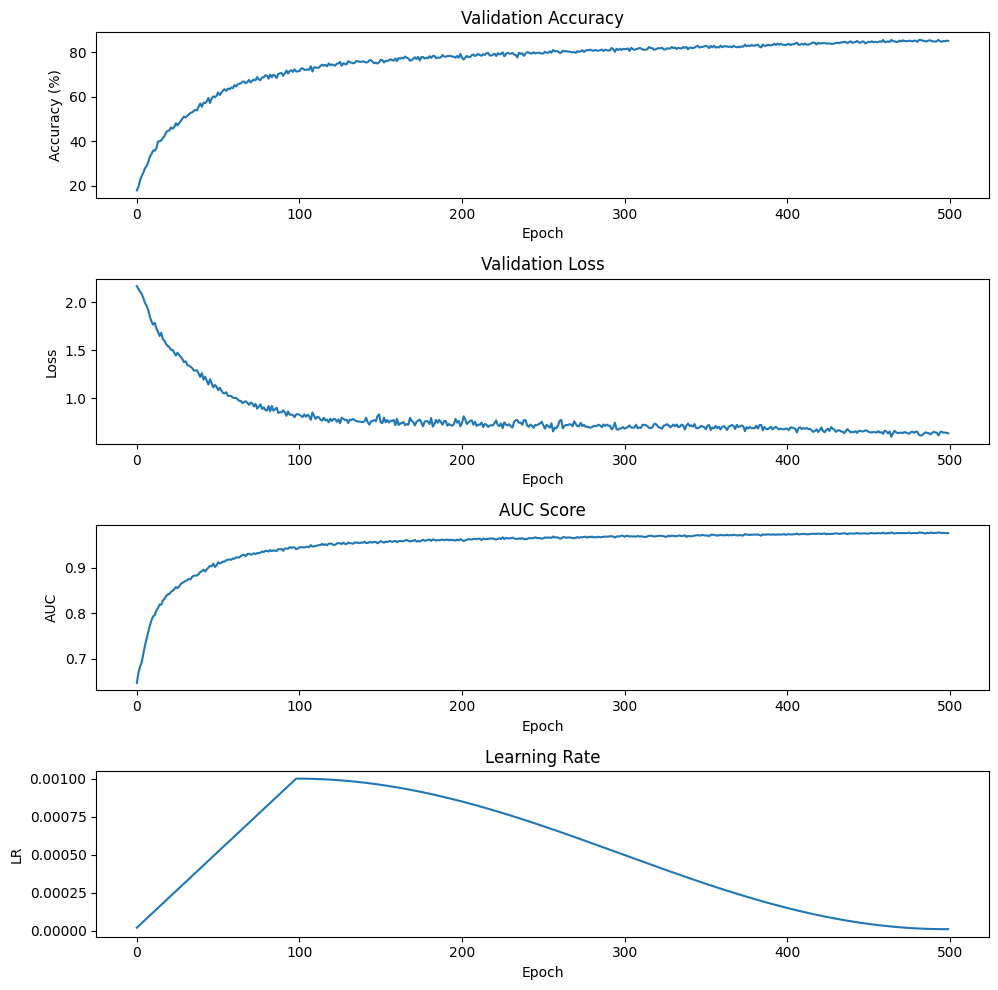

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10))

ax1.plot(accuracy_list)
ax1.set_title('Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')

ax2.plot(loss_list)
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

ax3.plot(auc_score_list)
ax3.set_title('AUC Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('AUC')

ax4.plot(learning_rate_list)
ax4.set_title('Learning Rate')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('LR')

plt.tight_layout()

plt.show()

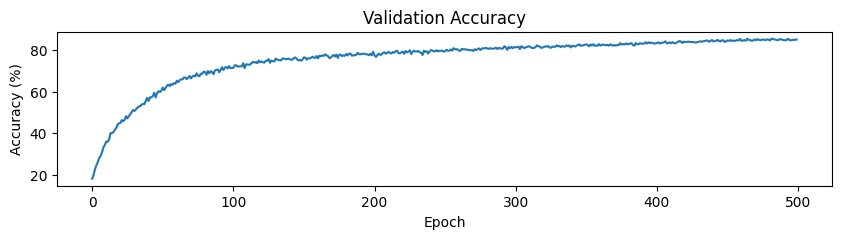

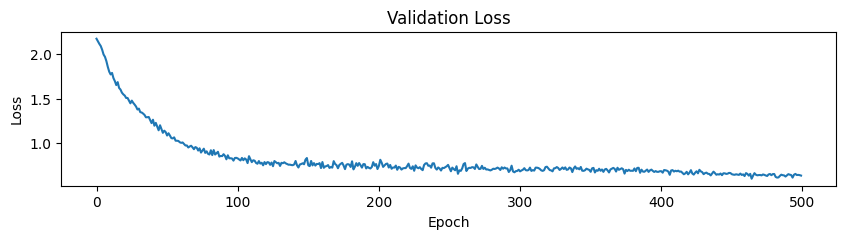

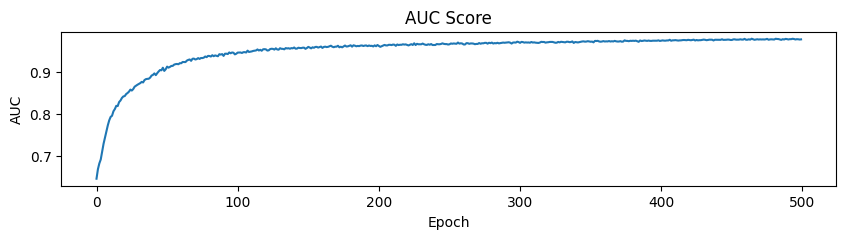

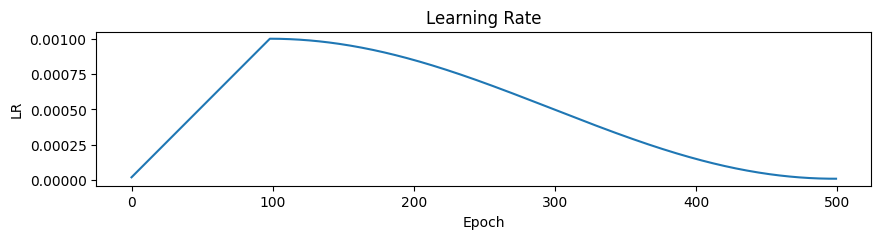

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
plt.plot(accuracy_list)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(loss_list)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(auc_score_list)
plt.title('AUC Score')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(learning_rate_list)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.show()
